## DSCI 552 PS 1 - Used Car Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
## import custom function to get feature names
from helper import get_feature_names

In [3]:
df = pd.read_csv(r'../data/used_car_dataset.csv')
print(df.shape)

(9997, 14)


In [4]:
df.head(3)

,price,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,21978.0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,4185.0,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,7693.0,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b


In [5]:
# df.describe()

In [6]:
# ## 14 attributes
# df.info()

# EDA / cleaning / transforming step
Your CEO said: “The dataset describes conditions of various used cars and their current prices.
I would like to learn **what drives prices of used cars**. 

1. Look at the dataset and find the **main factors**
that affect the **value** of a car – and then explain it to me. 

2. Additionally, assess the **impact** of some special modifications (denoted by **F1, F2, F3 and F4** in your dataset) on the price. This would help us to understand, **if we should make the modifications before selling a car or not**. I would
like to see the report, describing your main findings, on my desk, on Thursday, February 11,
2021 at 10 A.M. “

Hint: You are asked to **find general trends** in the data. Report whatever you think is the most important. Your CEO
doesn’t want to see a list that is 20-times long. She would like to learn just about some general trends. To give you
an example, one general trend could be “The price decrease with the age of the car. Holding all other factors
constant, with each year, the price of a car decreases by \$570. However, these dynamics are not constant. Value of
younger cars decreases faster than the value of an old car. For example, the value of cars that are less than 5 years
old, decreases nearly $2,500 per year.” (This is just an example; your numbers might be different). Your second
task you have to check both, the **impact** and the **statistical significance** of the **F1-F4 attributes** for making the price predictions.



In [7]:
### NOTE:
## Due to skewed datasets, we should clean data by:
## fill missing vals (median imputation)
## scale the datasets (minmaxscaler)
## remove outliers
## and one-hot encoding for categorical vars (to prep for model)

In [8]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
num_cols_no_price = ['year', 'odometer', 'F1', 'F2', 'F3']

In [9]:
## Normalize data
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)
outliers = list(set(outlier_locs))
## df2 is just df without the outliers
df2 = df.drop(df.index[outliers])
nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(9997, 14) (9603, 14)


In [10]:
# ## plot data
# df2.hist(bins=50, figsize=(16,8))
# plt.savefig('images/hist_1.png')

In [11]:
# ## View correlations btwn features
# # focus on effect on PRICE
# plt.figure(figsize=(10,6))
# sns.heatmap(df2.corr(), annot=True, cmap="hot_r")
# # plt.savefig('images/heatmap_1.png')

In [12]:
# ## boxplots for numerical vars
# fig, axes = plt.subplots(2, 3, sharex = False, figsize=(16,8))
# fig.suptitle('Boxplots')

# for i, var in enumerate(num_cols):
#     if i < 3:
#         row = 0
#     elif i >= 3: 
#         row = 1
#     col = i % 3
#     sns.boxplot(ax=axes[row,col], data=df2, x=var)
# plt.savefig('images/boxplots_1.png')

In [13]:
# ## Categorical vars and PRICE
# fig, axes = plt.subplots(2, 4, sharex = False, figsize=(16,8))
# fig.suptitle('Categorical Vars and Price')
# for i, var in enumerate(cat_cols):
#     if i < 4:
#         row = 0
#     elif i >= 4: 
#         row = 1
#     col = i % 4
#     axes[row][col] = sns.stripplot(x=var, y='price', data=df2, ax=axes[row][col])
# fig.tight_layout()
# plt.savefig('images/catplots_and_price_1.png')


## TODO: write about trends btwn price and various features (how they correlate as they go up or down) in the report 
From results of lin reg (using sm further on down the notebook): **year, type, cylinders, and F3** are most significant with price. So I will look specifically at these 

In [14]:
# df2.describe()
# # df2['price'].mode()

In [15]:
# g = sns.displot(data=df2, x='price', kde=True)
# g.fig.subplots_adjust(top=.95)
# g.ax.set_title("Distribution of Price")
# # plt.savefig('../images/PS_1/price_histogram.png')

In [16]:
# ## How does price vary across types?
# sns.boxplot(x='type', y='price', data=df2)
# plt.title("Price by Type")
# # plt.savefig('../images/PS_1/price_type_boxplot.png')|

Greater variability for pickup and truck types and they have similar medians. SUV and sedan have lower variability and more concentration of higher-priced outliers.

In [17]:
# ## How does price vary across num. of cylinders?
# sns.boxplot(x='cylinders', y='price', data=df2)
# plt.title("Price by Cylinders")
# # plt.savefig('../images/PS_1/price_cylinders_boxplot.png')

Greater variability for 6 and 8 cylinder cars. 

In [18]:
# plt.figure(figsize=(8,6))
# plt.title("Price By Year")
# sns.scatterplot(x='year', y='price', hue='cylinders', data=df2)
# # plt.scatter(x=df2['year'], y=df2['price'])
# # plt.savefig('../images/PS_1/price_by_year_cylinders.png')

In [19]:
# plt.figure(figsize=(8,6))
# plt.title("Price By Year")
# sns.scatterplot(x='year', y='price', hue='type', data=df2)
# # plt.savefig('../images/PS_1/price_by_year_type.png')

In [20]:
# plt.figure(figsize=(10,8))
# sns.scatterplot(x='F3', y='price', data=df2)
# # plt.scatter(x=df2['year'], y=df2['price'])

# Prediction Modeling , Tuning, and Evaluation 
Your Technical Manager said: “I would like you to propose a **predictive model**, that can be used to determine price of a used car. The problem is that the state-law demands that this model be easily interpretable. It means that we are restricted to use simple methods like **Linear Regression, Ridge Regression, LASSO and Elastic Net**. Additionally, we need to know how **accurate** the model is. You must choose the best model and report its **root mean square error**. Describe everything in your report and I will study it carefully”.
Hint: In the most typical approach, you need to build three datasets: **a training set, a validation set and a test set**. You will use **validation set** (for tuning model hyperparameters) to determine the best model; the test set to estimate model accuracy. In your report you should describe how you trained the models, how you selected the best one and how you tested its performance at the end.

# OLS regression for CEO part
## Transformation Pipeline

In [21]:
df3 = df2.drop(['price'],axis=1)
df3.head()

,year,manufacturer,condition,cylinders,fuel,odometer,transmission,type,paint_color,F1,F2,F3,F4
0,2016.0,ford,like new,6 cylinders,gas,80813.0,automatic,SUV,black,138,2.472286,0.059031,b
1,2008.0,ford,good,8 cylinders,gas,201800.0,automatic,SUV,white,415,2.285245,0.046328,c
2,2002.0,ford,excellent,6 cylinders,gas,145000.0,automatic,pickup,white,535,1.861461,0.158554,b
3,2016.0,ford,excellent,4 cylinders,gas,50103.0,automatic,sedan,white,3435,2.331671,0.213665,c
4,2005.0,ford,good,8 cylinders,gas,207663.0,automatic,truck,white,1212,2.061082,0.388724,b


In [22]:
"""
    Do Model WITHOUT scaling
    to get coeff and p-values from sm
"""
## TRANSFORM STEP (After outlier removal)
## Transforms the dataset to prep for model
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

## drop first dummy vars for Lin Reg
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols_no_price),
    ("categorical", OneHotEncoder(drop='first'), cat_cols)
])

arr = full_pipeline.fit_transform(df3)  ### dropped dummy vars
print(arr.shape) # After outlier removal
feature_names = get_feature_names(full_pipeline)

(9603, 21)


In [23]:
vifs = [variance_inflation_factor(arr, i) for i in range(arr.shape[1])]
print(len(vifs))
## NOTE: any VIF > 4 needs investigation for possible multicollinearity!
print(sorted(vifs)[::-1])

21
[299.26406445266826, 249.98519659110258, 6.100689119014561, 4.261642179609693, 3.233789149309924, 2.7768443447454043, 2.434597928073263, 2.0947094867570377, 2.075663063670362, 2.042564447221222, 2.0146611451577114, 1.9759717879300158, 1.947545652635113, 1.839372519729242, 1.829295445789961, 1.8128542011234523, 1.6952636550763105, 1.4731098862391672, 1.2713370940472877, 1.1792243125126092, 1.1647149809472024]


In [24]:
## Split in train/test/valid
X = arr
y = df2['price'].to_numpy()  ## target var is UNSCALED
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 21) (9603,)
(7682, 21) (1921, 21)


In [25]:
## OLS Linear Reg Model - using sm
## with UNSCALED data and dropped dummy vars
X_train_df = pd.DataFrame(X_train, columns=feature_names)
# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     565.9
Date:                Sat, 06 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:16:18   Log-Likelihood:                -78796.
No. Observations:                7682   AIC:                         1.576e+05
Df Residuals:                    7660   BIC:                         1.578e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                       -1.823e+06   4.91e+04    -37.164      0.000   -1.92e+06   -1.73e+06
numerical__year               913.7979     24.998     36.555      0.000     864.795     962.801
numerical__odometer            -0.0521      0.002    -32.604      0.000      -0.055      -0.049
numerical__F1                   0.3169      0.054      5.827      0.000       0.210       0.424
numerical__F2                -252.7499    786.228     -0.321      0.748   -1793.973    1288.473
numerical__F3                1.011e+04    792.827     12.756      0.000    8559.152    1.17e+04
categorical__x0_subaru       3061.0933    302.556     10.117      0.000    2468.000    3654.186
categorical__x1_fair        -1418.3343    464.605     -3.053      0.002   -2329.087    -507.582
categorical__x1_good         -297.1410    178.387     -1.666      0.096    -646.828      52.546
categorical__x1_like new     1286.7560    266.482      4.829      0.000     764.379    1809.133
categorical__x2_6 cylinders  4205.5344    235.085     17.889      0.000    3744.704    4666.365
categorical__x2_8 cylinders  5567.0898    291.819     19.077      0.000    4995.044    6139.136
categorical__x4_manual       3160.7834    406.188      7.782      0.000    2364.544    3957.023
categorical__x5_pickup       6075.2469    265.113     22.916      0.000    5555.552    6594.942
categorical__x5_sedan       -2833.1737    220.862    -12.828      0.000   -3266.124   -2400.224
categorical__x5_truck        5280.2196    245.088     21.544      0.000    4799.781    5760.658
categorical__x6_blue         -675.1528    282.494     -2.390      0.017   -1228.918    -121.387
categorical__x6_red          -149.3982    264.903     -0.564      0.573    -668.680     369.884
categorical__x6_silver       -873.7386    265.608     -3.290      0.001   -1394.403    -353.074
categorical__x6_white       -1491.5732    225.726     -6.608      0.000   -1934.057   -1049.089
categorical__x7_b              65.3542    191.254      0.342      0.733    -309.556     440.265
categorical__x7_c            -280.9212    194.890     -1.441      0.150    -662.959     101.117
==============================================================================
Omnibus:                     1015.318   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4702.931
Skew:                          -0.567   Prob(JB):                         0.00
Kurtosis:                       6.661   Cond. No.                     7.89e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+07. This might indicate that there are
strong multicollinearity or o

In [26]:
params = model.params
params.sort_values(ascending=False)

numerical__F3                  1.011331e+04
categorical__x5_pickup         6.075247e+03
categorical__x2_8 cylinders    5.567090e+03
categorical__x5_truck          5.280220e+03
categorical__x2_6 cylinders    4.205534e+03
categorical__x4_manual         3.160783e+03
categorical__x0_subaru         3.061093e+03
categorical__x1_like new       1.286756e+03
numerical__year                9.137979e+02
categorical__x7_b              6.535424e+01
numerical__F1                  3.169477e-01
numerical__odometer           -5.209295e-02
categorical__x6_red           -1.493982e+02
numerical__F2                 -2.527499e+02
categorical__x7_c             -2.809212e+02
categorical__x1_good          -2.971410e+02
categorical__x6_blue          -6.751528e+02
categorical__x6_silver        -8.737386e+02
categorical__x1_fair          -1.418334e+03
categorical__x6_white         -1.491573e+03
categorical__x5_sedan         -2.833174e+03
const                         -1.822998e+06
dtype: float64

In [91]:
## Predict on test values
X_test_df = pd.DataFrame(X_test, columns=feature_names)
X0_test = sm.add_constant(X_test_df)
y_pred = model.predict(X0_test)

In [102]:
## get RMSE
rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
rmse

7243.074155721239

# Regularized Regression for Modeling and Comparing Models

In [106]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('minmaxscaler', MinMaxScaler())
])

## pipeline for Regularized Regression
## DON'T drop any dummy vars
## and scale the data
full_pipeline = ColumnTransformer([
    ("numerical", num_pipeline, num_cols_no_price),
    ("categorical", OneHotEncoder(), cat_cols)
])

arr_cleaned = full_pipeline.fit_transform(df3)
print(arr_cleaned.shape) # After outlier removal
feature_names = get_feature_names(full_pipeline)

(9603, 29)


In [132]:
## Split in train/test/valid
X = arr_cleaned
y = df2['price'].to_numpy()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(9603, 29) (9603,)
(7682, 29) (1921, 29)


## Spot check / Compare models
#### try diff models compare results using kfold cv

In [133]:
# create a dict of standard models to evaluate
def define_models(models=dict()):
    models['linear_reg'] = LinearRegression()
    alpha = [round(x, 2) for x in np.linspace(0,1,11)]
    for a in alpha:
        models['lasso_reg_'+str(a)] = Lasso(alpha=a)
        models['ridge_reg_'+str(a)] = Ridge(alpha=a)
        models['en_reg_'+str(a)] = ElasticNet(alpha=a)
    return models
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
	# evaluate model
	scores = cross_val_score(estimator=model, X=X, y=y, scoring=metric, cv=folds, n_jobs=1)
	return scores

## see more metrics on sklearn docs
## https://scikit-learn.org/stable/modules/model_evaluation.html

## e.g. using RMSE (LOWER (i.e. more negative vals) = better fit)

# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='neg_root_mean_squared_error'):   
    results = dict()
    print(f"Using {metric} metric for scores below:\n")
    for name, model in models.items():
        # scores = robust_evaluate_model(X, y, model, folds, metric)
        scores = evaluate_model(X, y, model, folds, metric)
        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)
            print(f'{name}: Mean:{mean_score:.3f}, St.Dev:{std_score:.3f}')
        else:
            print(f'{name}: error')
    return results

In [134]:
models = define_models() 
results = evaluate_models(X, y, models)

Using neg_root_mean_squared_error metric for scores below:

linear_reg: Mean:-7016.673, St.Dev:153.561
lasso_reg_0.0: Mean:-6975.212, St.Dev:167.421
ridge_reg_0.0: Mean:-7052.890, St.Dev:214.013
en_reg_0.0: Mean:-6975.212, St.Dev:167.421
lasso_reg_0.1: Mean:-6975.211, St.Dev:167.421
ridge_reg_0.1: Mean:-6975.211, St.Dev:167.371
en_reg_0.1: Mean:-8037.064, St.Dev:187.070
lasso_reg_0.2: Mean:-6975.206, St.Dev:167.421
ridge_reg_0.2: Mean:-6975.212, St.Dev:167.321
en_reg_0.2: Mean:-8662.074, St.Dev:213.231
lasso_reg_0.3: Mean:-6975.196, St.Dev:167.424
ridge_reg_0.3: Mean:-6975.217, St.Dev:167.271
en_reg_0.3: Mean:-9051.750, St.Dev:228.828
lasso_reg_0.4: Mean:-6975.183, St.Dev:167.431
ridge_reg_0.4: Mean:-6975.224, St.Dev:167.222
en_reg_0.4: Mean:-9320.273, St.Dev:239.068
lasso_reg_0.5: Mean:-6975.156, St.Dev:167.441
ridge_reg_0.5: Mean:-6975.234, St.Dev:167.173
en_reg_0.5: Mean:-9518.029, St.Dev:246.300
lasso_reg_0.6: Mean:-6975.138, St.Dev:167.451
ridge_reg_0.6: Mean:-6975.247, St.Dev:167

In [135]:
mean_results = {name: np.round(np.mean(arr), 4) for name, arr in results.items()}
## sort results with 'best' models first (having lowest error scores)
sorted(mean_results.items(), key=lambda x: x[1])

[('en_reg_1.0', -10047.238),
 ('en_reg_0.9', -9976.0398),
 ('en_reg_0.8', -9892.3975),
 ('en_reg_0.7', -9792.481),
 ('en_reg_0.6', -9670.6159),
 ('en_reg_0.5', -9518.0295),
 ('en_reg_0.4', -9320.2725),
 ('en_reg_0.3', -9051.7502),
 ('en_reg_0.2', -8662.0743),
 ('en_reg_0.1', -8037.064),
 ('ridge_reg_0.0', -7052.8904),
 ('linear_reg', -7016.6731),
 ('ridge_reg_1.0', -6975.3253),
 ('ridge_reg_0.9', -6975.3017),
 ('ridge_reg_0.8', -6975.2807),
 ('ridge_reg_0.7', -6975.2624),
 ('ridge_reg_0.6', -6975.2468),
 ('ridge_reg_0.5', -6975.234),
 ('ridge_reg_0.4', -6975.224),
 ('ridge_reg_0.3', -6975.2168),
 ('lasso_reg_0.0', -6975.2125),
 ('en_reg_0.0', -6975.2125),
 ('ridge_reg_0.2', -6975.2124),
 ('ridge_reg_0.1', -6975.211),
 ('lasso_reg_0.1', -6975.2106),
 ('lasso_reg_0.2', -6975.2056),
 ('lasso_reg_0.3', -6975.1964),
 ('lasso_reg_0.4', -6975.1833),
 ('lasso_reg_0.5', -6975.1562),
 ('lasso_reg_0.6', -6975.1382),
 ('lasso_reg_0.7', -6975.1191),
 ('lasso_reg_0.8', -6975.0982),
 ('lasso_reg_0.9'

Looks like Lasso does the best at alpha=1.0

In [136]:
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k, np.mean(v)) for k, v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    print()
    for i in range(n):
        name = names[i]
        mean_score, std_score = np.mean(results[name]), np.std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' %
              (i+1, name, mean_score, std_score))
    # boxplot for the top n
    plt.boxplot(scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    plt.title('Top 10 Best Regularized Regression Models')
    plt.ylabel('RMSE')
    plt.savefig('../images/PS_1/spotcheck_models.png')


Rank=1, Name=lasso_reg_1.0, Score=-6975.059 (+/- 167.460)
Rank=2, Name=lasso_reg_0.9, Score=-6975.078 (+/- 167.459)
Rank=3, Name=lasso_reg_0.8, Score=-6975.098 (+/- 167.458)
Rank=4, Name=lasso_reg_0.7, Score=-6975.119 (+/- 167.456)
Rank=5, Name=lasso_reg_0.6, Score=-6975.138 (+/- 167.451)
Rank=6, Name=lasso_reg_0.5, Score=-6975.156 (+/- 167.441)
Rank=7, Name=lasso_reg_0.4, Score=-6975.183 (+/- 167.431)
Rank=8, Name=lasso_reg_0.3, Score=-6975.196 (+/- 167.424)
Rank=9, Name=lasso_reg_0.2, Score=-6975.206 (+/- 167.421)
Rank=10, Name=lasso_reg_0.1, Score=-6975.211 (+/- 167.421)


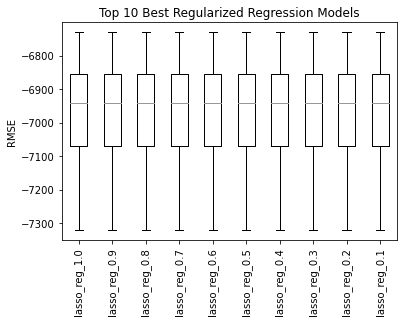

In [137]:
summarize_results(results)

In [138]:
n = X.shape[0]  ## sample size
p = X.shape[1]  ## num of predictors

In [141]:
## EN model
# en_reg = ElasticNet(alpha=1.0)
# print(en_reg)
# en_reg.fit(X_train, y_train)
# y_pred_en = en_reg.predict(X_test)
# print('Coefficients: \n', en_reg.coef_)
# print(f'Root Mean squared error: {mean_squared_error(y_test, y_pred_en, squared=False)}')
# print(f'MASE: {mean_absolute_error(y_test, y_pred_en)}')
# r2 = round(r2_score(y_test, y_pred_en),4)
# print(f'Coefficient of determination R^2: {r2}')

## Ridge model
ridge_reg = Ridge(alpha=1.0)
print(ridge_reg)
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
print('Coefficients: \n', ridge_reg.coef_)
print(f'Root Mean squared error: {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'MASE: {mean_absolute_error(y_test, y_pred)}')
r2 = round(r2_score(y_test, y_pred),4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Ridge()
Coefficients: 
 [ 33300.228052   -23184.96857779   2568.3272347     139.1360432
   6071.53242675  -1528.36836268   1528.36836266    119.1987654
  -1350.33911878   -190.60214299   1421.74249666  -3240.59261983
    948.58974245   2292.00287711      0.          -1564.35348712
   1564.35348712  -2135.4273378    3949.45700326  -4966.89722715
   3152.86756158    639.56485171    -37.82900442    485.48437396
   -236.365062     -850.85515919     71.86514407    136.64226909
   -208.50741319]
Root Mean squared error: 7241.694265383738
MASE: 4905.842494800269
Coefficient of determination R^2: 0.5697
Adjusted R^2 is 0.5684


In [142]:
# Lasso model
lasso_reg = Lasso(alpha=1.0)
print(lasso_reg)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
print('Coefficients: \n', lasso_reg.coef_)
print(f'Root Mean squared error: {mean_squared_error(y_test, y_pred_lasso, squared=False)}')
r2 = round(r2_score(y_test, y_pred_lasso) ,4)
print(f'Coefficient of determination R^2: {r2}')
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R^2 is {round(adj_r2,4)}')

Lasso()
Coefficients: 
 [ 3.36106479e+04 -2.32755136e+04  2.50170472e+03 -5.91178717e+01
  6.06742944e+03 -3.04748344e+03  0.00000000e+00  1.52005574e-01
 -1.39686171e+03 -2.93972146e+02  1.28119062e+03 -4.74619732e+03
 -5.43149969e+02  8.11238854e+02  0.00000000e+00 -3.13266713e+03
  1.13896837e-11 -2.61411761e+03  3.45572691e+03 -5.44544643e+03
  2.65910917e+03  6.68781225e+02  0.00000000e+00  5.19210756e+02
 -1.94302819e+02 -8.13166062e+02  0.00000000e+00  6.26865119e+01
 -2.77371226e+02]
Root Mean squared error: 7242.720354480176
Coefficient of determination R^2: 0.5695
Adjusted R^2 is 0.5682


# Conclusion of results
Using the UNSCALED data with first dummy variables dropped, the OLS Lin Reg model had the highest Adj R^2 value at ~0.6

But using the SCALED data without any dummy variables dropped, the 'best' regularized model (chosen using kfold CV) had lowest RMSE and slightly lower Adj R^2 compared to OLS

# TODO: BEFORE SUBMITTING CODE: 
### remember to remove all comments, change code structure so you didn't copy anyone

### add HO ML book and ml mastery website to citations